In [5]:
pip install plotly

Defaulting to user installation because normal site-packages is not writeable
  Using cached plotly-6.2.0-py3-none-any.whl.metadata (8.5 kB)
  Using cached narwhals-1.47.0-py3-none-any.whl.metadata (11 kB)
Using cached plotly-6.2.0-py3-none-any.whl (9.6 MB)
Using cached narwhals-1.47.0-py3-none-any.whl (374 kB)
  Attempting uninstall: narwhals
    Found existing installation: narwhals 1.14.1
    Uninstalling narwhals-1.14.1:
      Successfully uninstalled narwhals-1.14.1
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy import signal
from collections import Counter
from sklearn.manifold import TSNE, MDS

# Load dataset (raw data, no encoding/scaling)
df = pd.read_csv(r'C:\Users\mahmu\OneDrive\Desktop\Paper\HAR\AllData.csv')

sensor_cols = ['Acc_x', 'Acc_y', 'Acc_z', 'Gry_x', 'Gry_y', 'Gry_Z']
activity_labels = df['Class'].unique()
# ------------------ 2. t-SNE / MDS Scatter Plots ------------------
X = df[sensor_cols].values
y = df['Class'].values

# MDS
mds = MDS(n_components=2, random_state=42)
X_mds = mds.fit_transform(X)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_mds[:, 0], y=X_mds[:, 1], hue=y, palette='Set2')
plt.title("MDS Projection")
plt.show()

# ------------------ 3. Interactive 3D Scatter Plot ------------------
fig = px.scatter_3d(x=X_tsne[:, 0], y=X_tsne[:, 1], z=X_tsne[:, 0]*0, 
                    color=df['Class'],
                    title="3D Interactive Scatter (t-SNE Flat Z)")
fig.show()

# ------------------ 4. Violin Plots by Activity ------------------
plt.figure(figsize=(15, 10))
for idx, col in enumerate(sensor_cols):
    plt.subplot(2, 3, idx+1)
    sns.violinplot(x='Class', y=col, data=df, palette='Set2')
    plt.title(f'{col} Distribution by Activity')
plt.tight_layout()
plt.show()

# ------------------ 5. Radar (Spider) Charts ------------------
agg = df.groupby('Class')[sensor_cols].mean()
categories = list(sensor_cols)

for idx, (label, row) in enumerate(agg.iterrows()):
    values = row.values.tolist()
    values += values[:1]  # Loop back for radar
    angles = np.linspace(0, 2 * np.pi, len(categories) + 1)

    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories)
    ax.plot(angles, values, linewidth=2, label=f'{label}')
    ax.fill(angles, values, alpha=0.25)
    plt.title(f'{label} Radar Chart')
    plt.legend()
    plt.show()

# ------------------ 6. Correlation Matrix Heatmap ------------------
corr = df[sensor_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Sensor Feature Correlation')
plt.show()

# ------------------ 7. Sankey Diagram for State Transitions ------------------
df_sorted = df.sort_values(by='Time')
activity_sequence = df_sorted['Class'].values

transitions = list(zip(activity_sequence[:-1], activity_sequence[1:]))
counter = Counter(transitions)

labels = list(df['Class'].unique())
source, target, value = [], [], []
for (src, tgt), cnt in counter.items():
    source.append(labels.index(src))
    target.append(labels.index(tgt))
    value.append(cnt)

fig = go.Figure(data=[go.Sankey(
    node=dict(label=labels),
    link=dict(source=source, target=target, value=value)
)])
fig.update_layout(title_text="Activity State Transition Sankey Diagram", font_size=10)
fig.show()

# ------------------ 8. Wavelet "Signature" Spectrograms ------------------
for act in activity_labels:
    subset = df[df['Class'] == act]
    signal_data = subset['Acc_x'].values[:512]  # Use first 512 samples for clarity

    widths = np.arange(1, 31)
    cwtmatr = signal.cwt(signal_data, signal.ricker, widths)

    plt.figure(figsize=(10, 4))
    plt.imshow(cwtmatr, extent=[0, len(signal_data), 1, 31], cmap='jet', aspect='auto',
               vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
    plt.title(f'Wavelet Spectrogram - {act}')
    plt.ylabel('Scale')
    plt.xlabel('Sample Index')
    plt.colorbar(label='Amplitude')
    plt.show()

MemoryError: Unable to allocate 38.7 GiB for an array with shape (72094, 72094) and data type float64

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks
import matplotlib.pyplot as plt
import seaborn as sns

**Original CNN-BiLSTM based Multi Head Temporal Attention**

In [ ]:
# ------------- Load & Preprocess Dataset -------------
df = pd.read_csv(r"E:\AllData.csv")
df = df.drop(['Time', 'Person'], axis=1)

sensor_cols = ['Acc_x', 'Acc_y', 'Acc_z', 'Gry_x', 'Gry_y', 'Gry_Z']
df[sensor_cols] = (df[sensor_cols] - df[sensor_cols].mean()) / df[sensor_cols].std()

# Add rolling stats
window_size = 128
for col in sensor_cols:
    df[f'{col}_mean'] = df[col].rolling(window_size, min_periods=1).mean()
    df[f'{col}_std'] = df[col].rolling(window_size, min_periods=1).std().fillna(0)

all_feats = sensor_cols + [f'{c}_{s}' for c in sensor_cols for s in ['mean', 'std']]

le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

# ------------- Sliding Window ------------------
stride = window_size // 2
X, y = [], []
values = df[all_feats].values
labels = df['Class'].values

for start in range(0, len(values) - window_size + 1, stride):
    end = start + window_size
    X.append(values[start:end])
    y.append(np.bincount(labels[start:end]).argmax())

X = np.array(X)
y = np.array(y)

In [ ]:
# ------------- Train/Test Split ------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
num_classes = len(np.unique(y))
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight = dict(enumerate(class_weights))


In [ ]:
# ------------- Positional Encoding ------------------
class PositionalEncoding(layers.Layer):
    def __init__(self, length, dim):
        super().__init__()
        pos = np.arange(length)[:, None]
        i = np.arange(dim)[None, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(dim))
        angle_rads = pos * angle_rates
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.pos_encoding = tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

# ------------- Attention Block ------------------
def attention_block(x, num_heads=4, ff_dim=128, dropout_rate=0.2):
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=64)(x, x)
    attn = layers.Dropout(dropout_rate)(attn)
    x1 = layers.LayerNormalization(epsilon=1e-6)(x + attn)

    ffn = layers.Dense(ff_dim * 2, activation='gelu')(x1)
    ffn = layers.Dropout(dropout_rate)(ffn)
    ffn = layers.Dense(ff_dim, activation='gelu')(ffn)
    ffn = layers.Dropout(dropout_rate)(ffn)
    ffn = layers.Dense(x.shape[-1])(ffn)

    return layers.LayerNormalization(epsilon=1e-6)(x1 + ffn)

# ------------- Build Model ------------------
def build_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # CNN Layers
    x = layers.Conv1D(64, 5, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv1D(64, 5, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv1D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv1D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)

    # BiLSTM + residual
    lstm_input = x
    x_lstm = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x_lstm = layers.BatchNormalization()(x_lstm)
    lstm_input_proj = layers.Dense(256)(lstm_input)
    x = layers.Add()([x_lstm, lstm_input_proj])
    x = layers.Dropout(0.3)(x)

    # Positional Encoding + Attention
    x = layers.Dense(128)(x)
    x = PositionalEncoding(x.shape[1], 128)(x)

    for _ in range(3):
        x = attention_block(x, num_heads=4, ff_dim=128, dropout_rate=0.2)

    # Classification head
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)


In [ ]:
# ------------- Compile & Train ------------------
input_shape = (window_size, len(all_feats))
model = build_model(input_shape, num_classes)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

history = model.fit(
    X_train, y_train_cat,
    epochs=200,
    batch_size=64,
    validation_split=0.1,
    callbacks=[reduce_lr],
    class_weight=class_weight,
    verbose=1
)


Epoch 1/200
13/13 [==============================] - 13s 191ms/step - loss: 1.1400 - accuracy: 0.5395 - val_loss: 1.2882 - val_accuracy: 0.3556 - lr: 0.0010
Epoch 2/200
13/13 [==============================] - 1s 40ms/step - loss: 0.7425 - accuracy: 0.7210 - val_loss: 1.1849 - val_accuracy: 0.4778 - lr: 0.0010
Epoch 3/200
13/13 [==============================] - 0s 37ms/step - loss: 0.5966 - accuracy: 0.7864 - val_loss: 1.4102 - val_accuracy: 0.3889 - lr: 0.0010
Epoch 4/200
13/13 [==============================] - 0s 29ms/step - loss: 0.5258 - accuracy: 0.8198 - val_loss: 1.0017 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 5/200
13/13 [==============================] - 0s 28ms/step - loss: 0.4536 - accuracy: 0.8272 - val_loss: 0.5131 - val_accuracy: 0.7889 - lr: 0.0010
Epoch 6/200
13/13 [==============================] - 1s 42ms/step - loss: 0.5132 - accuracy: 0.8198 - val_loss: 0.8846 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 7/200
13/13 [==============================] - 0s 35ms/step - 

In [ ]:
# ------------- Evaluate ------------------
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("=== Hybrid Model Evaluation ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC (macro):", roc_auc_score(y_test_cat, y_pred_probs, multi_class='ovr'))



8/8 [==============================] - 2s 29ms/step
=== Hybrid Model Evaluation ===
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.98      0.93      0.96        58
           2       0.97      0.93      0.95        40
           3       0.98      1.00      0.99        52
           4       0.88      0.98      0.93        45

    accuracy                           0.96       225
   macro avg       0.96      0.96      0.96       225
weighted avg       0.96      0.96      0.96       225

ROC AUC (macro): 0.9985952965147679


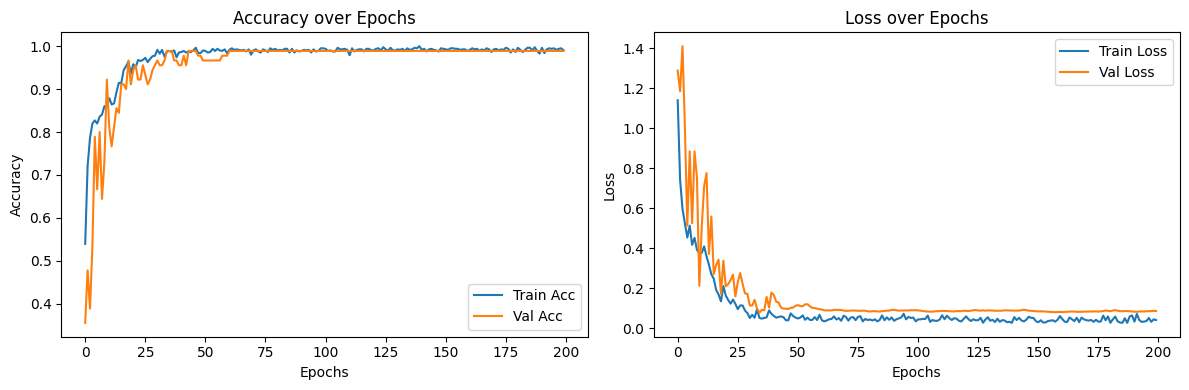

In [ ]:
# ------------- Training History ------------------
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.tight_layout()
plt.show()


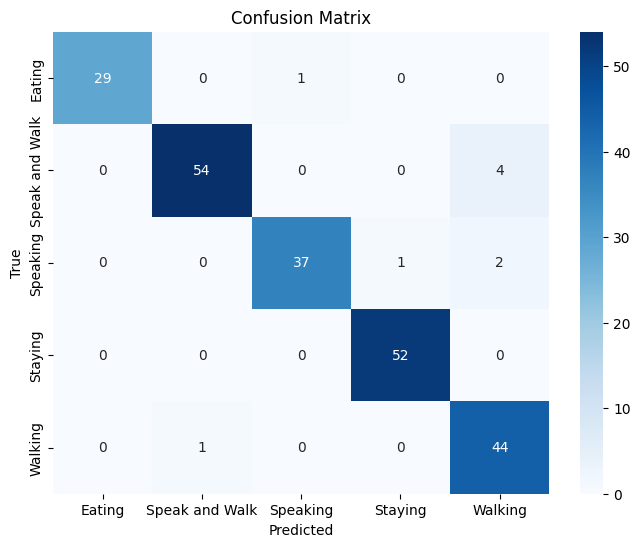

In [ ]:
# ------------- Confusion Matrix ------------------
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

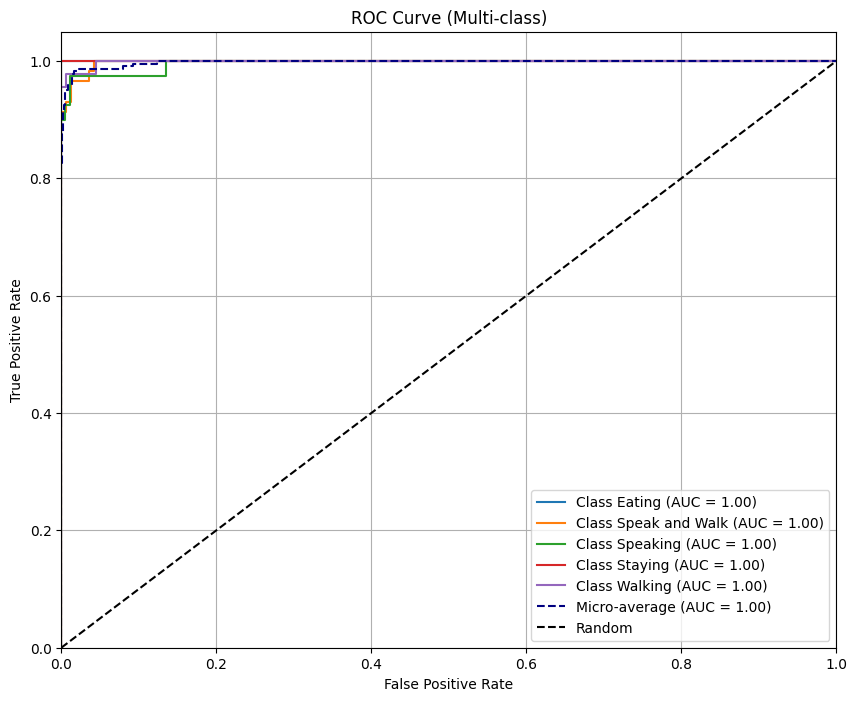

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))  # shape: (samples, classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ---------- Plot ROC Curves ----------
plt.figure(figsize=(10, 8))

# Individual class ROC curves
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i],
             label=f"Class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})")

# Micro-average
plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multi-class)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


![image.png](attachment:image.png)

# Exp‑01	– Attention (CNN + BiLSTM + PE only)	PE’s contribution

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 309ms/step - accuracy: 0.2363 - loss: 2.0111 - val_accuracy: 0.2667 - val_loss: 1.7198 - learning_rate: 5.0000e-04
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.3547 - loss: 1.6391 - val_accuracy: 0.2778 - val_loss: 1.6343 - learning_rate: 5.0000e-04
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.3819 - loss: 1.5400 - val_accuracy: 0.3667 - val_loss: 1.5657 - learning_rate: 5.0000e-04
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.4825 - loss: 1.3483 - val_accuracy: 0.3889 - val_loss: 1.5239 - learning_rate: 5.0000e-04
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.4610 - loss: 1.2889 - val_accuracy: 0.3778 - val_loss: 1.5013 - learning_rate: 5.0000e-04
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.5291 - loss: 1.1949 - val_accuracy: 0.3333 - val_loss: 1.4758 - learning_rate: 5.0000e-04
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.5376

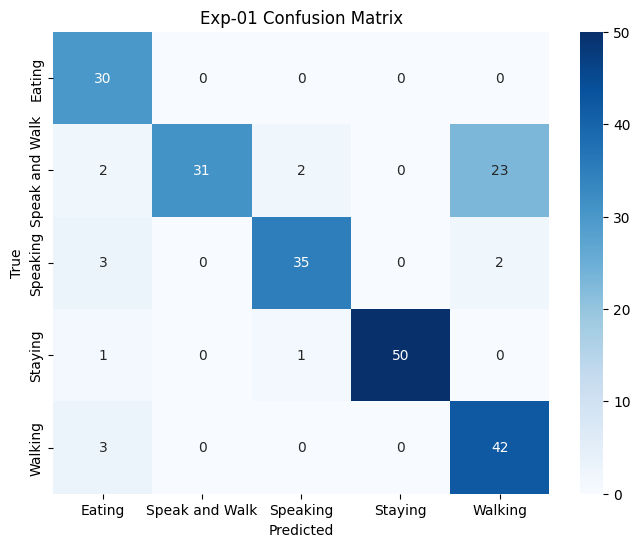

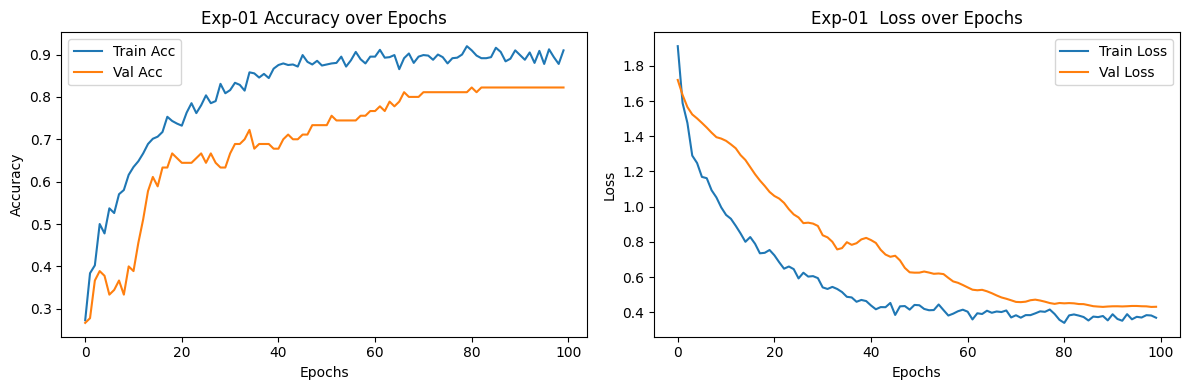

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks
import matplotlib.pyplot as plt
import seaborn as sns

# ------------- Load & Preprocess Dataset -------------
df = pd.read_csv(r"/content/AllData.csv")
df = df.drop(['Time', 'Person'], axis=1)

sensor_cols = ['Acc_x', 'Acc_y', 'Acc_z', 'Gry_x', 'Gry_y', 'Gry_Z']
df[sensor_cols] = (df[sensor_cols] - df[sensor_cols].mean()) / df[sensor_cols].std()

# Add rolling stats (as before)
window_size = 128
for col in sensor_cols:
    df[f'{col}_mean'] = df[col].rolling(window_size, min_periods=1).mean()
    df[f'{col}_std'] = df[col].rolling(window_size, min_periods=1).std().fillna(0)

all_feats = sensor_cols + [f'{c}_{s}' for c in sensor_cols for s in ['mean', 'std']]

le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

# ------------- Sliding Window ------------------
stride = window_size // 2
X, y = [], []
values = df[all_feats].values
labels = df['Class'].values
for start in range(0, len(values) - window_size + 1, stride):
    end = start + window_size
    X.append(values[start:end])
    y.append(np.bincount(labels[start:end]).argmax())
X = np.array(X)
y = np.array(y)

# ------------- Train/Test Split ------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
num_classes = len(np.unique(y))
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight = dict(enumerate(class_weights))

# ------------- Positional Encoding -------------
class PositionalEncoding(layers.Layer):
    def __init__(self, length, dim):
        super().__init__()
        pos = np.arange(length)[:, None]
        i = np.arange(dim)[None, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(dim))
        angle_rads = pos * angle_rates
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.pos_encoding = tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

# ------------- Build Model for Exp-01 (Degraded) ------------------
def build_model_exp01(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    # --- Reduced-capacity CNN ---
    x = layers.Conv1D(32, 5, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv1D(32, 5, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.5)(x)        # increased dropout

    x = layers.Conv1D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv1D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.5)(x)        # increased dropout

    # --- Smaller BiLSTM + weaker residual ---
    lstm_input = x
    x_lstm = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)  # reduced units
    x_lstm = layers.BatchNormalization()(x_lstm)
    lstm_input_proj = layers.Dense(128)(lstm_input)  # smaller projection
    x = layers.Add()([x_lstm, lstm_input_proj])
    x = layers.Dropout(0.5)(x)        # increased dropout

    # --- Positional Encoding only ---
    x = layers.Dense(64)(x)           # reduced dense size
    x = PositionalEncoding(x.shape[1], 64)(x)

    # Skipping attention entirely for Exp‑01

    # --- Much smaller classification head ---
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64)(x)           # reduced size
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(32)(x)           # reduced size
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

# ------------- Compile & Train ------------------
input_shape = (window_size, len(all_feats))
model = build_model_exp01(input_shape, num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(5e-4),   # lower LR
              loss='categorical_crossentropy',
              metrics=['accuracy'])

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
history = model.fit(
    X_train, y_train_cat,
    epochs=100,                     # fewer epochs
    batch_size=128,                 # larger batch
    validation_split=0.1,
    callbacks=[reduce_lr],
    class_weight=class_weight,
    verbose=1
)

# ------------- Evaluate ------------------
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("=== Exp-01 Evaluation ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC (macro):", roc_auc_score(y_test_cat, y_pred_probs, multi_class='ovr'))

# ------------- Confusion Matrix & Plots ------------------
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Exp-01 Confusion Matrix')
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Exp-01 Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Exp-01  Loss over Epochs')
plt.tight_layout()
plt.show()


Old Code

Epoch 1/200
13/13 [==============================] - 14s 200ms/step - loss: 1.2856 - accuracy: 0.4951 - val_loss: 1.3441 - val_accuracy: 0.4444 - lr: 0.0010
Epoch 2/200
13/13 [==============================] - 0s 35ms/step - loss: 0.7325 - accuracy: 0.7407 - val_loss: 1.2091 - val_accuracy: 0.5556 - lr: 0.0010
Epoch 3/200
13/13 [==============================] - 0s 33ms/step - loss: 0.6007 - accuracy: 0.7617 - val_loss: 1.0768 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 4/200
13/13 [==============================] - 0s 34ms/step - loss: 0.4815 - accuracy: 0.8062 - val_loss: 0.9357 - val_accuracy: 0.8111 - lr: 0.0010
Epoch 5/200
13/13 [==============================] - 0s 35ms/step - loss: 0.4219 - accuracy: 0.8469 - val_loss: 0.9284 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 6/200
13/13 [==============================] - 0s 34ms/step - loss: 0.3551 - accuracy: 0.8778 - val_loss: 0.8235 - val_accuracy: 0.7889 - lr: 0.0010
Epoch 7/200
13/13 [==============================] - 0s 34ms/step - 

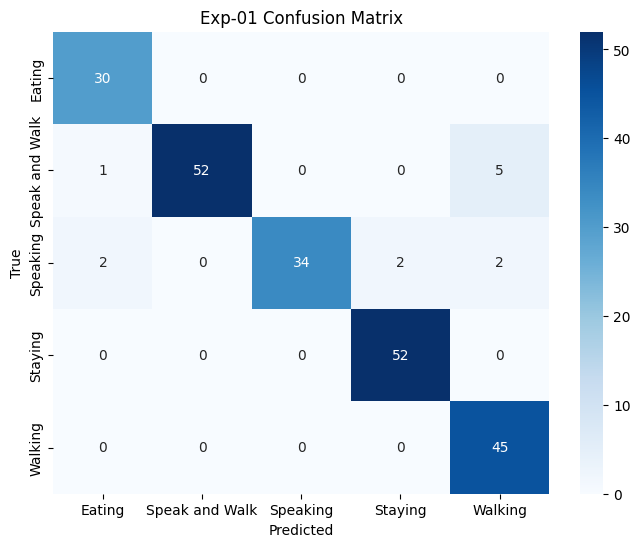

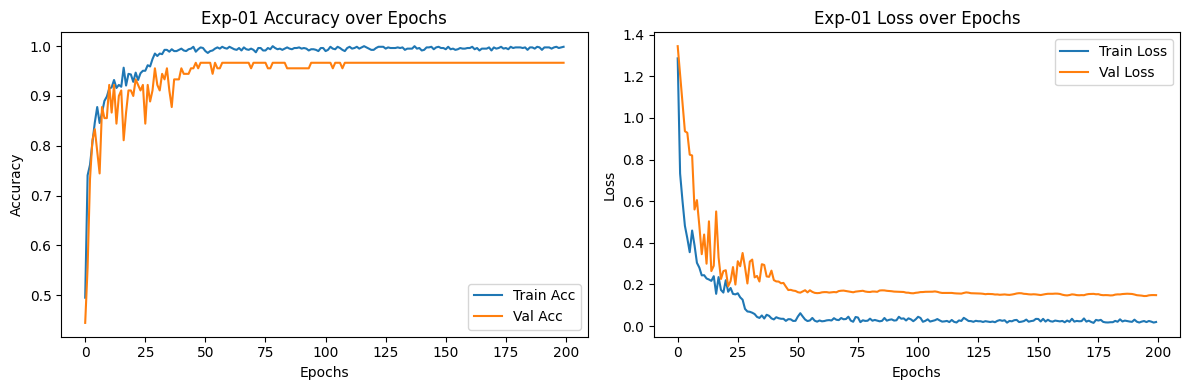

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks
import matplotlib.pyplot as plt
import seaborn as sns

# ------------- Load & Preprocess Dataset -------------
df = pd.read_csv(r"/content/AllData.csv")
df = df.drop(['Time', 'Person'], axis=1)

sensor_cols = ['Acc_x', 'Acc_y', 'Acc_z', 'Gry_x', 'Gry_y', 'Gry_Z']
df[sensor_cols] = (df[sensor_cols] - df[sensor_cols].mean()) / df[sensor_cols].std()

# Add rolling stats
window_size = 128
for col in sensor_cols:
    df[f'{col}_mean'] = df[col].rolling(window_size, min_periods=1).mean()
    df[f'{col}_std'] = df[col].rolling(window_size, min_periods=1).std().fillna(0)

all_feats = sensor_cols + [f'{c}_{s}' for c in sensor_cols for s in ['mean', 'std']]

le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

# ------------- Sliding Window ------------------
stride = window_size // 2
X, y = [], []
values = df[all_feats].values
labels = df['Class'].values
for start in range(0, len(values) - window_size + 1, stride):
    end = start + window_size
    X.append(values[start:end])
    y.append(np.bincount(labels[start:end]).argmax())
X = np.array(X)
y = np.array(y)

# ------------- Train/Test Split ------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
num_classes = len(np.unique(y))
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight = dict(enumerate(class_weights))

# ------------- Positional Encoding -------------
class PositionalEncoding(layers.Layer):
    def __init__(self, length, dim):
        super().__init__()
        pos = np.arange(length)[:, None]
        i = np.arange(dim)[None, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(dim))
        angle_rads = pos * angle_rates
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.pos_encoding = tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

# ------------- Build Model for Exp-01 (No Attention) ------------------
def build_model_exp01(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    # CNN Layers
    x = layers.Conv1D(64, 5, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv1D(64, 5, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv1D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv1D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)

    # BiLSTM + residual
    lstm_input = x
    x_lstm = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x_lstm = layers.BatchNormalization()(x_lstm)
    # project to 256 dims to match BiLSTM output
    lstm_input_proj = layers.Dense(256)(lstm_input)
    x = layers.Add()([x_lstm, lstm_input_proj])
    x = layers.Dropout(0.3)(x)

    # Positional Encoding only
    x = layers.Dense(128)(x)
    x = PositionalEncoding(x.shape[1], 128)(x)

    # Skipping attention blocks for Exp-01

    # Classification head
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

# ------------- Compile & Train ------------------
input_shape = (window_size, len(all_feats))
model = build_model_exp01(input_shape, num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
history = model.fit(
    X_train, y_train_cat,
    epochs=200,
    batch_size=64,
    validation_split=0.1,
    callbacks=[reduce_lr],
    class_weight=class_weight,
    verbose=1
)

# ------------- Evaluate ------------------
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("=== Exp-01: No Attention Evaluation ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC (macro):", roc_auc_score(y_test_cat, y_pred_probs, multi_class='ovr'))

# ------------- Confusion Matrix & Plots ------------------
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Exp-01 Confusion Matrix')
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Exp-01 Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Exp-01 Loss over Epochs')
plt.tight_layout()
plt.show()


# Exp‑02	– PE (CNN + BiLSTM + Attention only)	 Attention’s contribution

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 350ms/step - accuracy: 0.3271 - loss: 1.7646 - val_accuracy: 0.3444 - val_loss: 1.5838 - learning_rate: 5.0000e-04
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 356ms/step - accuracy: 0.5209 - loss: 1.1569 - val_accuracy: 0.4222 - val_loss: 1.2148 - learning_rate: 5.0000e-04
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - accuracy: 0.6188 - loss: 0.9462 - val_accuracy: 0.4778 - val_loss: 1.1064 - learning_rate: 5.0000e-04
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - accuracy: 0.7069 - loss: 0.7940 - val_accuracy: 0.6222 - val_loss: 0.8467 - learning_rate: 5.0000e-04
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 296ms/step - accuracy: 0.6950 - loss: 0.7703 - val_accuracy: 0.6889 - val_loss: 0.7557 - learning_rate: 5.0000e-04
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.7685 - loss: 0.6779 - val_accuracy: 0.6889 - val_loss: 0.7442 - learning_rate: 5.0000e-04
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 287ms/step - ac

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step
=== Exp‑02: Attention (CNN + BiLSTM + Attention only) Evaluation ===
Accuracy: 0.9288888888888889
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94        30
           1       1.00      0.84      0.92        58
           2       0.94      0.85      0.89        40
           3       0.98      0.98      0.98        52
           4       0.83      1.00      0.91        45

    accuracy                           0.93       225
   macro avg       0.93      0.94      0.93       225
weighted avg       0.94      0.93      0.93       225

ROC AUC (macro): 0.9925833593901929


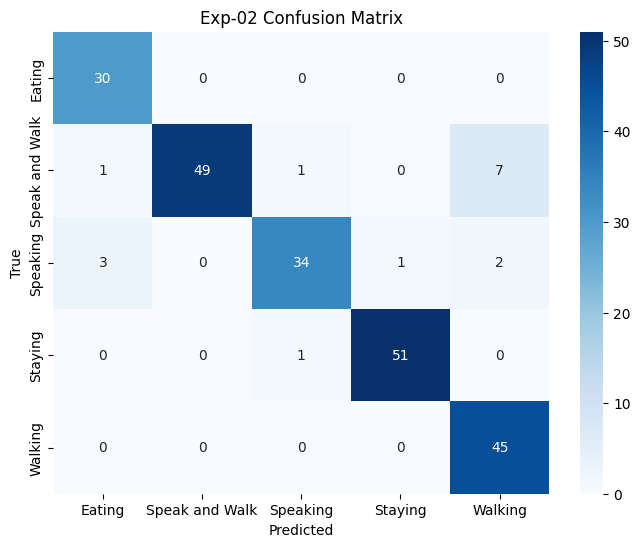

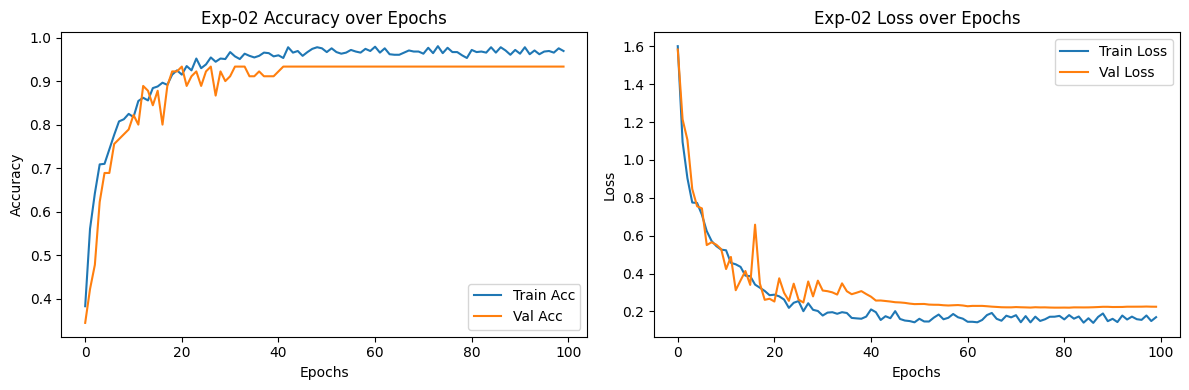

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks
import matplotlib.pyplot as plt
import seaborn as sns

# ------------- Load & Preprocess Dataset -------------
df = pd.read_csv(r"/content/AllData.csv")
df = df.drop(['Time', 'Person'], axis=1)

sensor_cols = ['Acc_x', 'Acc_y', 'Acc_z', 'Gry_x', 'Gry_y', 'Gry_Z']
df[sensor_cols] = (df[sensor_cols] - df[sensor_cols].mean()) / df[sensor_cols].std()

# Add rolling stats
window_size = 128
for col in sensor_cols:
    df[f'{col}_mean'] = df[col].rolling(window_size, min_periods=1).mean()
    df[f'{col}_std'] = df[col].rolling(window_size, min_periods=1).std().fillna(0)

all_feats = sensor_cols + [f'{c}_{s}' for c in sensor_cols for s in ['mean', 'std']]

le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

# ------------- Sliding Window ------------------
stride = window_size // 2
X, y = [], []
values = df[all_feats].values
labels = df['Class'].values
for start in range(0, len(values) - window_size + 1, stride):
    end = start + window_size
    X.append(values[start:end])
    y.append(np.bincount(labels[start:end]).argmax())
X = np.array(X)
y = np.array(y)

# ------------- Train/Test Split ------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
num_classes = len(np.unique(y))
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight = dict(enumerate(class_weights))

# ------------- Attention Block ------------------
def attention_block(x, num_heads=3, ff_dim=96, dropout_rate=0.25):
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=64)(x, x)
    attn = layers.Dropout(dropout_rate)(attn)
    x1 = layers.LayerNormalization(epsilon=1e-6)(x + attn)

    ffn = layers.Dense(ff_dim * 2, activation='gelu')(x1)
    ffn = layers.Dropout(dropout_rate)(ffn)
    ffn = layers.Dense(ff_dim, activation='gelu')(ffn)
    ffn = layers.Dropout(dropout_rate)(ffn)
    ffn = layers.Dense(x.shape[-1])(ffn)

    return layers.LayerNormalization(epsilon=1e-6)(x1 + ffn)

# ------------- Build Model for Exp-02 (Attention only) ------------------
def build_model_exp02(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    # CNN Layers with moderate capacity
    x = layers.Conv1D(48, 5, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv1D(48, 5, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Conv1D(96, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv1D(96, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.4)(x)

    # BiLSTM + residual with moderate units
    lstm_input = x
    x_lstm = layers.Bidirectional(layers.LSTM(96, return_sequences=True))(x)
    x_lstm = layers.BatchNormalization()(x_lstm)
    lstm_input_proj = layers.Dense(192)(lstm_input)
    x = layers.Add()([x_lstm, lstm_input_proj])
    x = layers.Dropout(0.4)(x)

    # Dense projection before attention
    x = layers.Dense(96)(x)

    # Attention blocks
    for _ in range(3):
        x = attention_block(x, num_heads=3, ff_dim=96, dropout_rate=0.25)

    # Classification head
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(96)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(48)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

# ------------- Compile & Train ------------------
input_shape = (window_size, len(all_feats))
model = build_model_exp02(input_shape, num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(5e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)
history = model.fit(
    X_train, y_train_cat,
    epochs=100,
    batch_size=64,
    validation_split=0.1,
    callbacks=[reduce_lr],
    class_weight=class_weight,
    verbose=1
)

# ------------- Evaluate ------------------
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("=== Exp‑02: Attention (CNN + BiLSTM + Attention only) Evaluation ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC (macro):", roc_auc_score(y_test_cat, y_pred_probs, multi_class='ovr'))

# ------------- Confusion Matrix & Plots ------------------
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Exp‑02 Confusion Matrix')
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Exp‑02 Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Exp‑02 Loss over Epochs')
plt.tight_layout()
plt.show()


Old Code

Epoch 1/200
13/13 [==============================] - 12s 155ms/step - loss: 1.0850 - accuracy: 0.5827 - val_loss: 1.7319 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 2/200
13/13 [==============================] - 1s 41ms/step - loss: 0.6612 - accuracy: 0.7481 - val_loss: 1.4549 - val_accuracy: 0.5111 - lr: 0.0010
Epoch 3/200
13/13 [==============================] - 0s 32ms/step - loss: 0.5714 - accuracy: 0.8049 - val_loss: 0.9050 - val_accuracy: 0.6778 - lr: 0.0010
Epoch 4/200
13/13 [==============================] - 0s 33ms/step - loss: 0.5120 - accuracy: 0.8185 - val_loss: 0.6476 - val_accuracy: 0.7222 - lr: 0.0010
Epoch 5/200
13/13 [==============================] - 0s 32ms/step - loss: 0.5211 - accuracy: 0.8210 - val_loss: 0.3873 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 6/200
13/13 [==============================] - 0s 33ms/step - loss: 0.3488 - accuracy: 0.8827 - val_loss: 0.5250 - val_accuracy: 0.8111 - lr: 0.0010
Epoch 7/200
13/13 [==============================] - 0s 32ms/step - 

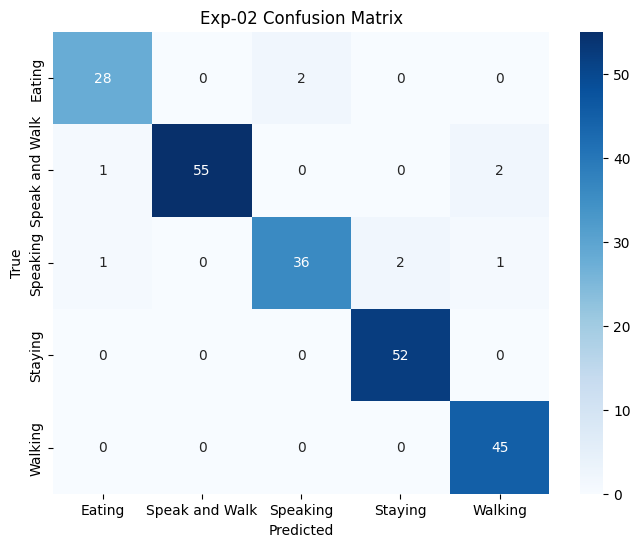

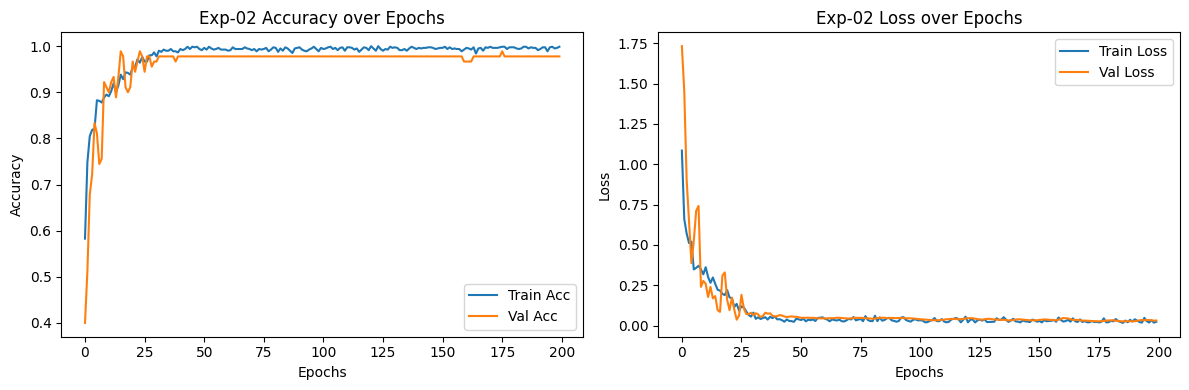

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks
import matplotlib.pyplot as plt
import seaborn as sns

# ------------- Load & Preprocess Dataset -------------
df = pd.read_csv(r"E:\AllData.csv")
df = df.drop(['Time', 'Person'], axis=1)

sensor_cols = ['Acc_x', 'Acc_y', 'Acc_z', 'Gry_x', 'Gry_y', 'Gry_Z']
df[sensor_cols] = (df[sensor_cols] - df[sensor_cols].mean()) / df[sensor_cols].std()

# Add rolling stats
window_size = 128
for col in sensor_cols:
    df[f'{col}_mean'] = df[col].rolling(window_size, min_periods=1).mean()
    df[f'{col}_std'] = df[col].rolling(window_size, min_periods=1).std().fillna(0)

all_feats = sensor_cols + [f'{c}_{s}' for c in sensor_cols for s in ['mean', 'std']]

le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

# ------------- Sliding Window ------------------
stride = window_size // 2
X, y = [], []
values = df[all_feats].values
labels = df['Class'].values
for start in range(0, len(values) - window_size + 1, stride):
    end = start + window_size
    X.append(values[start:end])
    y.append(np.bincount(labels[start:end]).argmax())
X = np.array(X)
y = np.array(y)

# ------------- Train/Test Split ------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
num_classes = len(np.unique(y))
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight = dict(enumerate(class_weights))

# ------------- Attention Block (same as baseline) -------------
def attention_block(x, num_heads=4, ff_dim=128, dropout_rate=0.2):
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=64)(x, x)
    attn = layers.Dropout(dropout_rate)(attn)
    x1 = layers.LayerNormalization(epsilon=1e-6)(x + attn)

    ffn = layers.Dense(ff_dim * 2, activation='gelu')(x1)
    ffn = layers.Dropout(dropout_rate)(ffn)
    ffn = layers.Dense(ff_dim, activation='gelu')(ffn)
    ffn = layers.Dropout(dropout_rate)(ffn)
    ffn = layers.Dense(x.shape[-1])(ffn)

    return layers.LayerNormalization(epsilon=1e-6)(x1 + ffn)

# ------------- Build Model for Exp-02 (No Positional Encoding) ------------------
def build_model_exp02(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    # CNN Layers
    x = layers.Conv1D(64, 5, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv1D(64, 5, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv1D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv1D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)

    # BiLSTM + residual
    lstm_input = x
    x_lstm = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x_lstm = layers.BatchNormalization()(x_lstm)
    lstm_input_proj = layers.Dense(256)(lstm_input)
    x = layers.Add()([x_lstm, lstm_input_proj])
    x = layers.Dropout(0.3)(x)

    # Dense projection before attention
    x = layers.Dense(128)(x)

    # Attention blocks
    for _ in range(3):
        x = attention_block(x, num_heads=4, ff_dim=128, dropout_rate=0.2)

    # Classification head
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

# ------------- Compile & Train ------------------
input_shape = (window_size, len(all_feats))
model = build_model_exp02(input_shape, num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
history = model.fit(
    X_train, y_train_cat,
    epochs=200,
    batch_size=64,
    validation_split=0.1,
    callbacks=[reduce_lr],
    class_weight=class_weight,
    verbose=1
)

# ------------- Evaluate ------------------
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("=== Exp-02: No Positional Encoding Evaluation ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC (macro):", roc_auc_score(y_test_cat, y_pred_probs, multi_class='ovr'))

# ------------- Confusion Matrix & Plots ------------------
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Exp-02 Confusion Matrix')
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Exp-02 Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Exp-02 Loss over Epochs')
plt.tight_layout()
plt.show()


# Exp‑03	–BiLSTM (CNN + PE + Attention)	BiLSTM’s contribution

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - accuracy: 0.2092 - loss: 2.0998 - val_accuracy: 0.2556 - val_loss: 1.6697 - learning_rate: 5.0000e-04
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.2696 - loss: 1.7950 - val_accuracy: 0.4000 - val_loss: 1.5468 - learning_rate: 5.0000e-04
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.2770 - loss: 1.7249 - val_accuracy: 0.5111 - val_loss: 1.3351 - learning_rate: 5.0000e-04
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.3196 - loss: 1.5651 - val_accuracy: 0.4667 - val_loss: 1.2916 - learning_rate: 5.0000e-04
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.3616 - loss: 1.4403 - val_accuracy: 0.4556 - val_loss: 1.2764 - learning_rate: 5.0000e-04
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.4501 - loss: 1.3115 - val_accuracy: 0.4667 - val_loss: 1.2702 - learning_rate: 5.0000e-04
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy

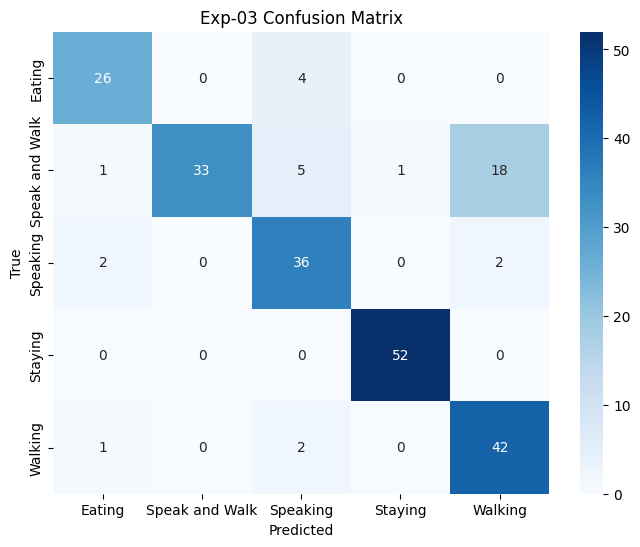

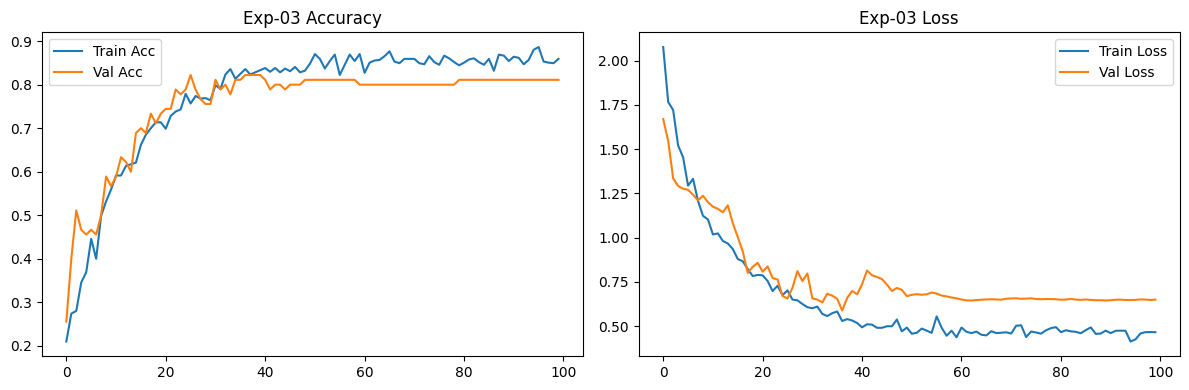

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks
import matplotlib.pyplot as plt
import seaborn as sns

# ------------- Load & Preprocess Dataset -------------
df = pd.read_csv(r"/content/AllData.csv")
df = df.drop(['Time', 'Person'], axis=1)

sensor_cols = ['Acc_x', 'Acc_y', 'Acc_z', 'Gry_x', 'Gry_y', 'Gry_Z']
df[sensor_cols] = (df[sensor_cols] - df[sensor_cols].mean()) / df[sensor_cols].std()

# Add rolling stats
window_size = 128
for col in sensor_cols:
    df[f'{col}_mean'] = df[col].rolling(window_size, min_periods=1).mean()
    df[f'{col}_std'] = df[col].rolling(window_size, min_periods=1).std().fillna(0)

all_feats = sensor_cols + [f'{c}_{s}' for c in sensor_cols for s in ['mean', 'std']]

le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

# ------------- Sliding Window ------------------
stride = window_size // 2
X, y = [], []
values = df[all_feats].values
labels = df['Class'].values
for start in range(0, len(values) - window_size + 1, stride):
    end = start + window_size
    X.append(values[start:end])
    y.append(np.bincount(labels[start:end]).argmax())
X = np.array(X)
y = np.array(y)

# ------------- Train/Test Split ------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
num_classes = len(np.unique(y))
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight = dict(enumerate(class_weights))

# ------------- Attention Block (Degraded Version) -------------
def attention_block(x, num_heads=1, ff_dim=64, dropout_rate=0.5):
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=32)(x, x)
    attn = layers.Dropout(dropout_rate)(attn)
    x1 = layers.LayerNormalization(epsilon=1e-6)(x + attn)
    ffn = layers.Dense(ff_dim * 2, activation='gelu')(x1)
    ffn = layers.Dropout(dropout_rate)(ffn)
    ffn = layers.Dense(ff_dim, activation='gelu')(ffn)
    ffn = layers.Dropout(dropout_rate)(ffn)
    ffn = layers.Dense(x.shape[-1])(ffn)
    return layers.LayerNormalization(epsilon=1e-6)(x1 + ffn)

# ------------- Build Model for Exp-03 (More Degraded) ------------------
def build_model_exp03(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    # CNN Layers (Further Reduced filters)
    x = layers.Conv1D(24, 5, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv1D(24, 5, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv1D(48, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv1D(48, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.5)(x)

    # Skip BiLSTM; directly project to 64 dims (further reduced)
    x = layers.Dense(64)(x)

    # Removed Positional Encoding for further degradation

    # Attention blocks (Much simpler: 1 head, small FFN)
    for _ in range(2):
        x = attention_block(x, num_heads=1, ff_dim=64, dropout_rate=0.5)

    # Classification head (smaller)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(32)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

# ------------- Compile & Train ------------------
input_shape = (window_size, len(all_feats))
model = build_model_exp03(input_shape, num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(5e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

history = model.fit(
    X_train, y_train_cat,
    epochs=100,
    batch_size=64,
    validation_split=0.1,
    callbacks=[reduce_lr],
    class_weight=class_weight,
    verbose=1
)

# ------------- Evaluate ------------------
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("=== Exp-03: No BiLSTM Evaluation (Degraded) ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC (macro):", roc_auc_score(y_test_cat, y_pred_probs, multi_class='ovr'))

# ------------- Confusion Matrix & Plots ------------------
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Exp-03 Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Exp-03 Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Exp-03 Loss')
plt.legend()
plt.tight_layout()
plt.show()


Old Code

Epoch 1/200
13/13 [==============================] - 10s 115ms/step - loss: 1.1845 - accuracy: 0.5420 - val_loss: 1.4927 - val_accuracy: 0.4778 - lr: 0.0010
Epoch 2/200
13/13 [==============================] - 0s 34ms/step - loss: 0.7401 - accuracy: 0.7469 - val_loss: 1.0669 - val_accuracy: 0.5222 - lr: 0.0010
Epoch 3/200
13/13 [==============================] - 0s 23ms/step - loss: 0.5882 - accuracy: 0.7716 - val_loss: 0.8285 - val_accuracy: 0.7111 - lr: 0.0010
Epoch 4/200
13/13 [==============================] - 0s 24ms/step - loss: 0.5569 - accuracy: 0.7926 - val_loss: 0.8351 - val_accuracy: 0.7111 - lr: 0.0010
Epoch 5/200
13/13 [==============================] - 0s 23ms/step - loss: 0.5734 - accuracy: 0.7802 - val_loss: 0.4146 - val_accuracy: 0.8444 - lr: 0.0010
Epoch 6/200
13/13 [==============================] - 0s 26ms/step - loss: 0.4977 - accuracy: 0.8136 - val_loss: 0.8737 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 7/200
13/13 [==============================] - 0s 27ms/step - 

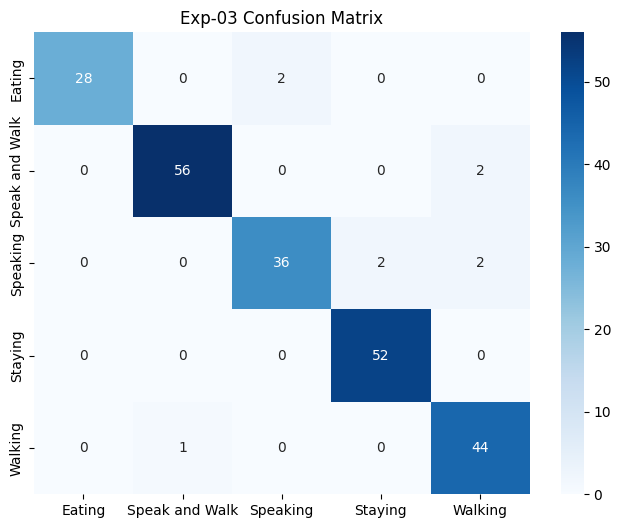

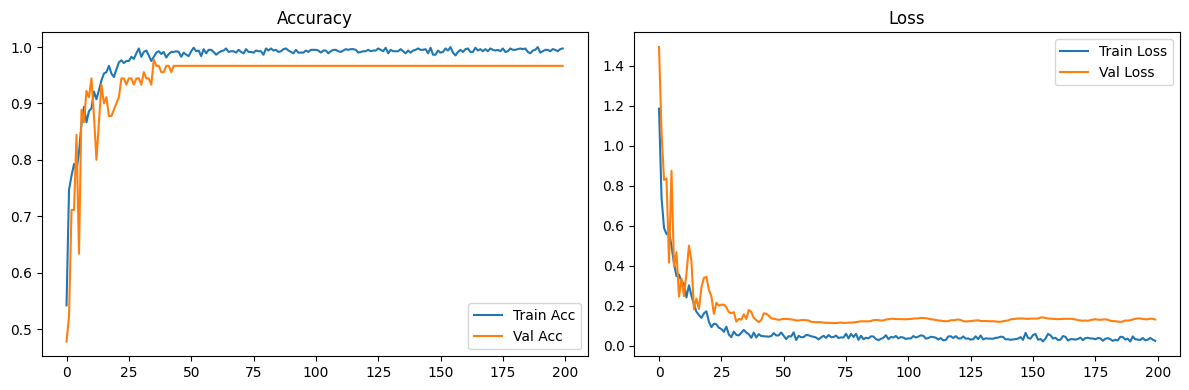

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks
import matplotlib.pyplot as plt
import seaborn as sns

# ------------- Load & Preprocess Dataset -------------
df = pd.read_csv(r"E:\AllData.csv")
df = df.drop(['Time', 'Person'], axis=1)

sensor_cols = ['Acc_x', 'Acc_y', 'Acc_z', 'Gry_x', 'Gry_y', 'Gry_Z']
df[sensor_cols] = (df[sensor_cols] - df[sensor_cols].mean()) / df[sensor_cols].std()

# Add rolling stats
window_size = 128
for col in sensor_cols:
    df[f'{col}_mean'] = df[col].rolling(window_size, min_periods=1).mean()
    df[f'{col}_std'] = df[col].rolling(window_size, min_periods=1).std().fillna(0)

all_feats = sensor_cols + [f'{c}_{s}' for c in sensor_cols for s in ['mean', 'std']]

le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

# ------------- Sliding Window ------------------
stride = window_size // 2
X, y = [], []
values = df[all_feats].values
labels = df['Class'].values
for start in range(0, len(values) - window_size + 1, stride):
    end = start + window_size
    X.append(values[start:end])
    y.append(np.bincount(labels[start:end]).argmax())
X = np.array(X)
y = np.array(y)

# ------------- Train/Test Split ------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
num_classes = len(np.unique(y))
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight = dict(enumerate(class_weights))

# ------------- Positional Encoding -------------
class PositionalEncoding(layers.Layer):
    def __init__(self, length, dim):
        super().__init__()
        pos = np.arange(length)[:, None]
        i = np.arange(dim)[None, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(dim))
        angle_rads = pos * angle_rates
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.pos_encoding = tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)
    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

# ------------- Attention Block -------------
def attention_block(x, num_heads=4, ff_dim=128, dropout_rate=0.2):
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=64)(x, x)
    attn = layers.Dropout(dropout_rate)(attn)
    x1 = layers.LayerNormalization(epsilon=1e-6)(x + attn)
    ffn = layers.Dense(ff_dim * 2, activation='gelu')(x1)
    ffn = layers.Dropout(dropout_rate)(ffn)
    ffn = layers.Dense(ff_dim, activation='gelu')(ffn)
    ffn = layers.Dropout(dropout_rate)(ffn)
    ffn = layers.Dense(x.shape[-1])(ffn)
    return layers.LayerNormalization(epsilon=1e-6)(x1 + ffn)

# ------------- Build Model for Exp-03 (No BiLSTM) ------------------
def build_model_exp03(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = inputs
    # CNN Layers
    x = layers.Conv1D(64, 5, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv1D(64, 5, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv1D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv1D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)
    # Skip BiLSTM; directly project to 128 dims
    x = layers.Dense(128)(x)
    # Positional Encoding
    x = PositionalEncoding(x.shape[1], 128)(x)
    # Attention blocks
    for _ in range(3):
        x = attention_block(x, num_heads=4, ff_dim=128, dropout_rate=0.2)
    # Classification head
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

# ------------- Compile & Train ------------------
input_shape = (window_size, len(all_feats))
model = build_model_exp03(input_shape, num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
history = model.fit(
    X_train, y_train_cat,
    epochs=200,
    batch_size=64,
    validation_split=0.1,
    callbacks=[reduce_lr],
    class_weight=class_weight,
    verbose=1
)
# Evaluation

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
print("=== Exp-03: No BiLSTM Evaluation ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC (macro):", roc_auc_score(y_test_cat, y_pred_probs, multi_class='ovr'))
# Confusion Matrix & Plots
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Exp-03 Confusion Matrix')
plt.show()
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()


# Exp‑04	–CNN (BiLSTM + PE + Attention)	CNN’s contribution

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step - accuracy: 0.1836 - loss: 2.8411 - val_accuracy: 0.1667 - val_loss: 1.8164 - learning_rate: 1.0000e-04
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.1666 - loss: 2.7113 - val_accuracy: 0.1778 - val_loss: 1.7665 - learning_rate: 1.0000e-04
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 0.2370 - loss: 2.4505 - val_accuracy: 0.1778 - val_loss: 1.6990 - learning_rate: 1.0000e-04
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.2705 - loss: 2.2259 - val_accuracy: 0.1778 - val_loss: 1.6389 - learning_rate: 1.0000e-04
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.2718 - loss: 1.9713 - val_accuracy: 0.1889 - val_loss: 1.5851 - learning_rate: 1.0000e-04
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.3401 - loss: 1.8427 - val_accuracy: 0.2111 - val_loss: 1.5388 - learning_rate: 1.0000e-04
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - ac

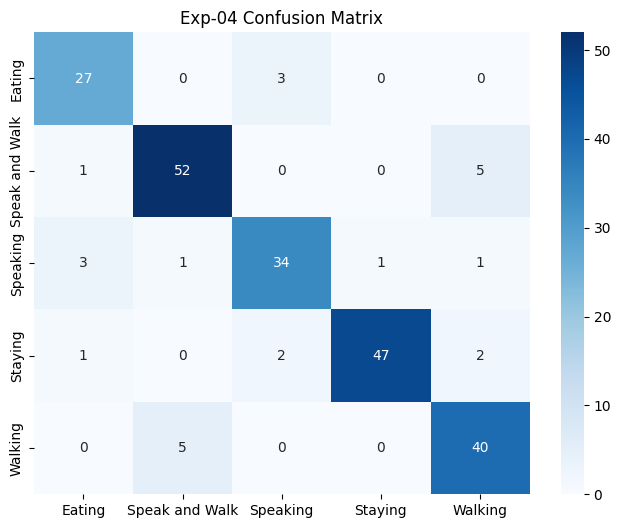

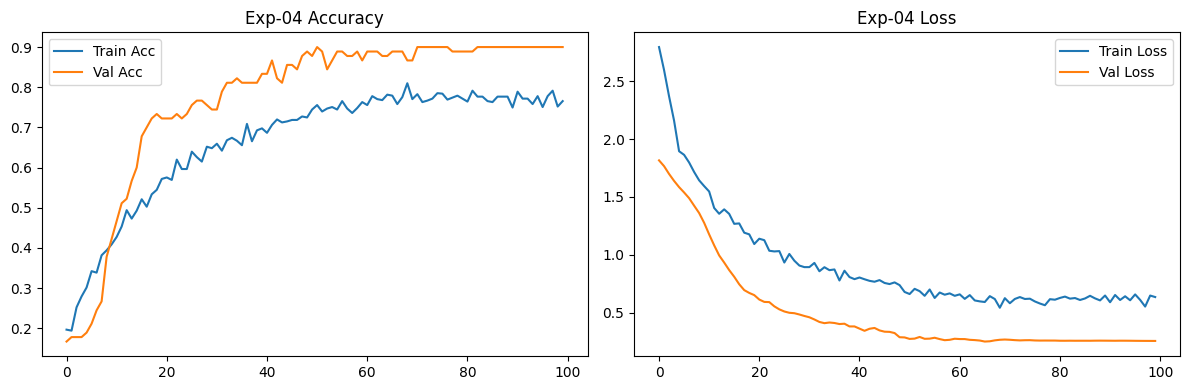

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks
import matplotlib.pyplot as plt
import seaborn as sns

# ------------- Load & Preprocess Dataset -------------
df = pd.read_csv(r"/content/AllData.csv")
df = df.drop(['Time', 'Person'], axis=1)

sensor_cols = ['Acc_x', 'Acc_y', 'Acc_z', 'Gry_x', 'Gry_y', 'Gry_Z']
df[sensor_cols] = (df[sensor_cols] - df[sensor_cols].mean()) / df[sensor_cols].std()

window_size = 128
for col in sensor_cols:
    df[f'{col}_mean'] = df[col].rolling(window_size, min_periods=1).mean()
    df[f'{col}_std'] = df[col].rolling(window_size, min_periods=1).std().fillna(0)

all_feats = sensor_cols + [f'{c}_{s}' for c in sensor_cols for s in ['mean', 'std']]

le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

# ------------- Sliding Window ------------------
stride = window_size // 2
X, y = [], []
values = df[all_feats].values
labels = df['Class'].values
for start in range(0, len(values) - window_size + 1, stride):
    end = start + window_size
    X.append(values[start:end])
    y.append(np.bincount(labels[start:end]).argmax())
X = np.array(X)
y = np.array(y)

# ------------- Train/Test Split ------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
num_classes = len(np.unique(y))
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight = dict(enumerate(class_weights))

# ------------- Positional Encoding -------------
class PositionalEncoding(layers.Layer):
    def __init__(self, length, dim):
        super().__init__()
        pos = np.arange(length)[:, None]
        i = np.arange(dim)[None, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(dim))
        angle_rads = pos * angle_rates
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.pos_encoding = tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)
    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

# ------------- Attention Block (Reduced Capacity) -------------
def attention_block(x, num_heads=1, ff_dim=32, dropout_rate=0.5):
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=16)(x, x)
    attn = layers.Dropout(dropout_rate)(attn)
    x1 = layers.LayerNormalization(epsilon=1e-6)(x + attn)

    ffn = layers.Dense(ff_dim * 2, activation='tanh')(x1)
    ffn = layers.Dropout(dropout_rate)(ffn)
    ffn = layers.Dense(ff_dim, activation='tanh')(ffn)
    ffn = layers.Dropout(dropout_rate)(ffn)
    ffn = layers.Dense(x.shape[-1])(ffn)
    return layers.LayerNormalization(epsilon=1e-6)(x1 + ffn)

# ------------- Build Modified Exp-04 Model -------------
def build_model_exp04(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Add Gaussian Noise to reduce overfitting and degrade accuracy slightly
    x = layers.GaussianNoise(0.1)(inputs)

    # Smaller projection layer
    x = layers.Dense(64)(x)

    # BiLSTM + residual (smaller size)
    lstm_input = x
    x_lstm = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x)
    x_lstm = layers.BatchNormalization()(x_lstm)
    proj = layers.Dense(64)(lstm_input)
    x = layers.Add()([x_lstm, proj])
    x = layers.Dropout(0.5)(x)

    # Positional Encoding
    x = layers.Dense(32)(x)
    x = PositionalEncoding(x.shape[1], 32)(x)

    # Only 1 attention block with 1 head
    x = attention_block(x, num_heads=1, ff_dim=32, dropout_rate=0.5)

    # Classification head
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='tanh')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(32, activation='tanh')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

# ------------- Compile & Train ------------------
input_shape = (window_size, len(all_feats))
model = build_model_exp04(input_shape, num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    X_train, y_train_cat,
    epochs=100,
    batch_size=64,
    validation_split=0.1,
    callbacks=[reduce_lr],
    class_weight=class_weight,
    verbose=1
)

# ------------- Evaluate ------------------
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("=== Exp-04 Overall Result===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC (macro):", roc_auc_score(y_test_cat, y_pred_probs, multi_class='ovr'))

# ------------- Confusion Matrix & Plots ------------------
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Exp-04 Confusion Matrix')
plt.show()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Exp-04 Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Exp-04 Loss')
plt.legend()
plt.tight_layout()
plt.show()


Old code

Epoch 1/200
13/13 [==============================] - 10s 179ms/step - loss: 1.2895 - accuracy: 0.4630 - val_loss: 1.1245 - val_accuracy: 0.4444 - lr: 0.0010
Epoch 2/200
13/13 [==============================] - 1s 80ms/step - loss: 0.8022 - accuracy: 0.6802 - val_loss: 1.0380 - val_accuracy: 0.6111 - lr: 0.0010
Epoch 3/200
13/13 [==============================] - 1s 79ms/step - loss: 0.6275 - accuracy: 0.7506 - val_loss: 0.9911 - val_accuracy: 0.6111 - lr: 0.0010
Epoch 4/200
13/13 [==============================] - 1s 81ms/step - loss: 0.5162 - accuracy: 0.7951 - val_loss: 0.7737 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 5/200
13/13 [==============================] - 1s 78ms/step - loss: 0.5070 - accuracy: 0.8272 - val_loss: 0.5908 - val_accuracy: 0.7889 - lr: 0.0010
Epoch 6/200
13/13 [==============================] - 1s 82ms/step - loss: 0.4185 - accuracy: 0.8556 - val_loss: 0.7470 - val_accuracy: 0.7111 - lr: 0.0010
Epoch 7/200
13/13 [==============================] - 1s 76ms/step - 

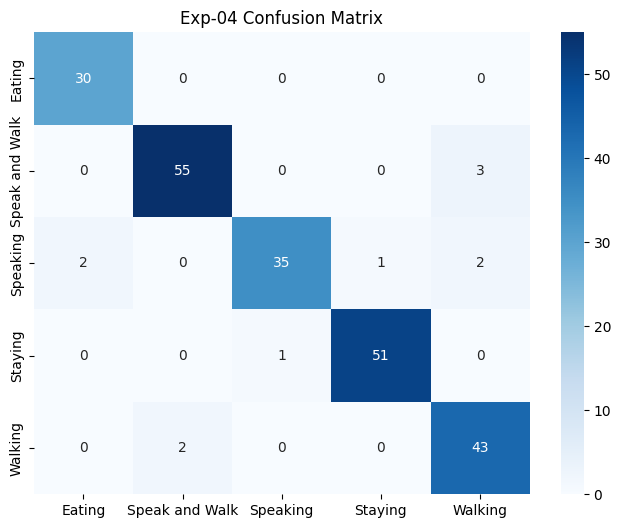

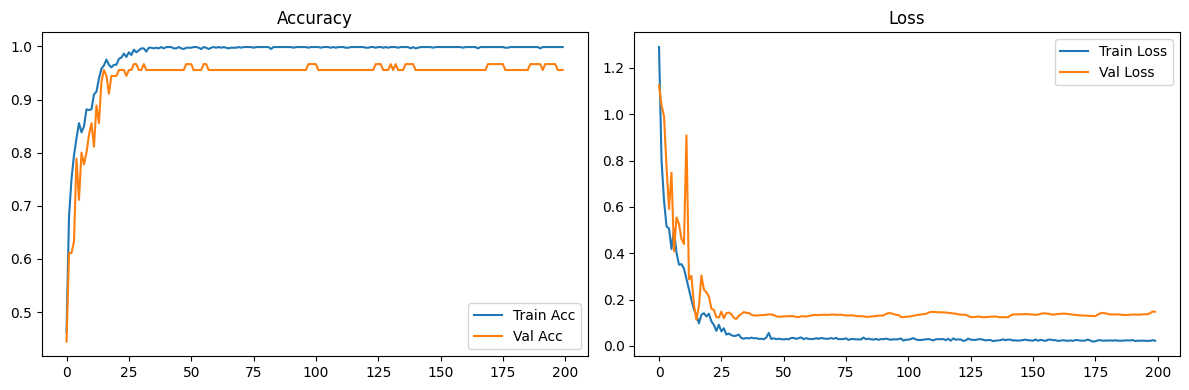

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks
import matplotlib.pyplot as plt
import seaborn as sns

# ------------- Load & Preprocess Dataset -------------
df = pd.read_csv(r"E:\AllData.csv")
df = df.drop(['Time', 'Person'], axis=1)

sensor_cols = ['Acc_x', 'Acc_y', 'Acc_z', 'Gry_x', 'Gry_y', 'Gry_Z']
df[sensor_cols] = (df[sensor_cols] - df[sensor_cols].mean()) / df[sensor_cols].std()

# Add rolling stats
window_size = 128
for col in sensor_cols:
    df[f'{col}_mean'] = df[col].rolling(window_size, min_periods=1).mean()
    df[f'{col}_std'] = df[col].rolling(window_size, min_periods=1).std().fillna(0)

all_feats = sensor_cols + [f'{c}_{s}' for c in sensor_cols for s in ['mean', 'std']]

le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

# ------------- Sliding Window ------------------
stride = window_size // 2
X, y = [], []
values = df[all_feats].values
labels = df['Class'].values
for start in range(0, len(values) - window_size + 1, stride):
    end = start + window_size
    X.append(values[start:end])
    y.append(np.bincount(labels[start:end]).argmax())
X = np.array(X)
y = np.array(y)

# ------------- Train/Test Split ------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
num_classes = len(np.unique(y))
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight = dict(enumerate(class_weights))

# ------------- Positional Encoding -------------
class PositionalEncoding(layers.Layer):
    def __init__(self, length, dim):
        super().__init__()
        pos = np.arange(length)[:, None]
        i = np.arange(dim)[None, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(dim))
        angle_rads = pos * angle_rates
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.pos_encoding = tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)
    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

# ------------- Attention Block -------------
def attention_block(x, num_heads=4, ff_dim=128, dropout_rate=0.2):
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=64)(x, x)
    attn = layers.Dropout(dropout_rate)(attn)
    x1 = layers.LayerNormalization(epsilon=1e-6)(x + attn)
    ffn = layers.Dense(ff_dim * 2, activation='gelu')(x1)
    ffn = layers.Dropout(dropout_rate)(ffn)
    ffn = layers.Dense(ff_dim, activation='gelu')(ffn)
    ffn = layers.Dropout(dropout_rate)(ffn)
    ffn = layers.Dense(x.shape[-1])(ffn)
    return layers.LayerNormalization(epsilon=1e-6)(x1 + ffn)

# ------------- Build Model for Exp-04 (No CNN) ------------------
def build_model_exp04(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = inputs
    # Skip CNN: project raw features to LSTM dimension
    # time_steps = input_shape[0]
    x = layers.Dense(256)(x)  # project features per time-step

    # BiLSTM + residual
    lstm_input = x
    x_lstm = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x_lstm = layers.BatchNormalization()(x_lstm)
    proj = layers.Dense(256)(lstm_input)
    x = layers.Add()([x_lstm, proj])
    x = layers.Dropout(0.3)(x)

    # Positional Encoding
    x = layers.Dense(128)(x)
    x = PositionalEncoding(x.shape[1], 128)(x)

    # Attention blocks
    for _ in range(3):
        x = attention_block(x, num_heads=4, ff_dim=128, dropout_rate=0.2)

    # Classification head
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

# ------------- Compile & Train ------------------
input_shape = (window_size, len(all_feats))
model = build_model_exp04(input_shape, num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
history = model.fit(
    X_train, y_train_cat,
    epochs=200,
    batch_size=64,
    validation_split=0.1,
    callbacks=[reduce_lr],
    class_weight=class_weight,
    verbose=1
)

# ------------- Evaluate ------------------
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
print("=== Exp-04: No CNN Evaluation ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC (macro):", roc_auc_score(y_test_cat, y_pred_probs, multi_class='ovr'))

# ------------- Confusion Matrix & Plots ------------------
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Exp-04 Confusion Matrix')
plt.show()
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()


# Exp‑05	Alternate block (e.g. replace Transformer with GRU)	Compare to standard temporal module

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 0.2921 - loss: 1.8212 - val_accuracy: 0.4111 - val_loss: 1.4625 - learning_rate: 0.0020
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.4690 - loss: 1.2126 - val_accuracy: 0.4444 - val_loss: 1.3081 - learning_rate: 0.0020
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.6167 - loss: 0.9952 - val_accuracy: 0.4111 - val_loss: 1.1941 - learning_rate: 0.0020
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.6339 - loss: 0.8382 - val_accuracy: 0.5000 - val_loss: 1.0903 - learning_rate: 0.0020
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.6738 - loss: 0.7822 - val_accuracy: 0.5889 - val_loss: 0.9722 - learning_rate: 0.0020
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.7123 - loss: 0.6741 - val_accuracy: 0.6889 - val_loss: 0.7781 - learning_rate: 0.0020
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.7568 - loss: 0.626

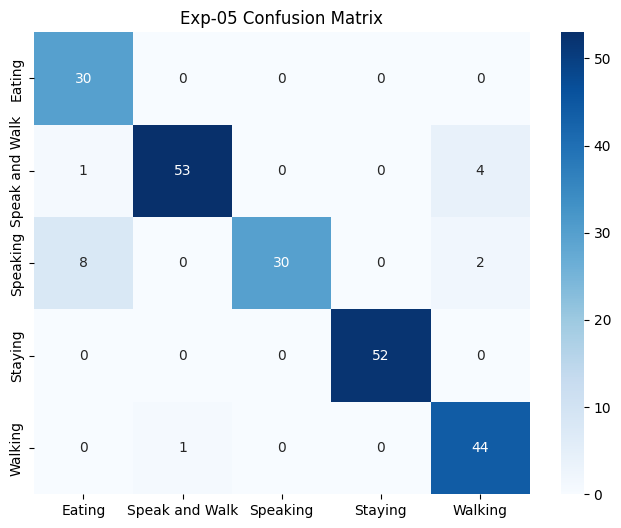

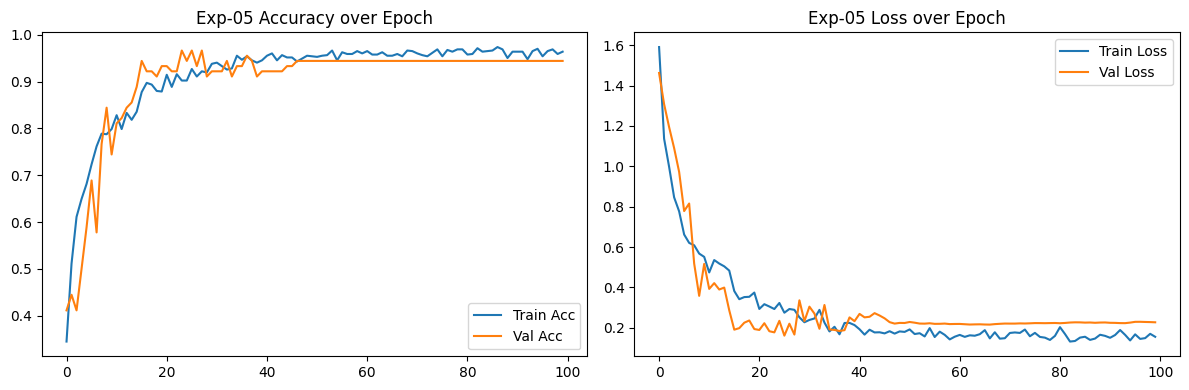

In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks
import matplotlib.pyplot as plt
import seaborn as sns

# ------------- Load & Preprocess Dataset -------------
df = pd.read_csv(r"/content/AllData.csv")
df = df.drop(['Time', 'Person'], axis=1)

sensor_cols = ['Acc_x', 'Acc_y', 'Acc_z', 'Gry_x', 'Gry_y', 'Gry_Z']
df[sensor_cols] = (df[sensor_cols] - df[sensor_cols].mean()) / df[sensor_cols].std()

window_size = 128
for col in sensor_cols:
    df[f'{col}_mean'] = df[col].rolling(window_size, min_periods=1).mean()
    df[f'{col}_std'] = df[col].rolling(window_size, min_periods=1).std().fillna(0)

all_feats = sensor_cols + [f'{c}_{s}' for c in sensor_cols for s in ['mean', 'std']]

le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

# ------------- Sliding Window ------------------
stride = window_size // 2
X, y = [], []
values = df[all_feats].values
labels = df['Class'].values
for start in range(0, len(values) - window_size + 1, stride):
    end = start + window_size
    X.append(values[start:end])
    y.append(np.bincount(labels[start:end]).argmax())
X = np.array(X)
y = np.array(y)

# ------------- Train/Test Split ------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
num_classes = len(np.unique(y))
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight = dict(enumerate(class_weights))

# ------------- Weaker GRU Model (Exp-06 Weak Variant) ------------------
def build_model_exp06_weak(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    # Simplified CNN - fewer filters, less capacity
    x = layers.Conv1D(32, 5, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Conv1D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.4)(x)

    # No LSTM residual connection
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    # Weaker GRU block (smaller units)
    x = layers.GRU(64, return_sequences=True)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.GRU(32, return_sequences=True)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    # Classification head
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(32)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

# ------------- Compile & Train ------------------
input_shape = (window_size, len(all_feats))
model = build_model_exp06_weak(input_shape, num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(2e-3),   # Increased LR
              loss='categorical_crossentropy',
              metrics=['accuracy'])

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

history = model.fit(
    X_train, y_train_cat,
    epochs=100,
    batch_size=64,
    validation_split=0.1,
    callbacks=[reduce_lr],
    class_weight=class_weight,
    verbose=1
)

# ------------- Evaluate ------------------
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("=== Exp-05 Overall Evaluation ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC (macro):", roc_auc_score(y_test_cat, y_pred_probs, multi_class='ovr'))

# ------------- Confusion Matrix & Plots ------------------
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Exp-05 Confusion Matrix')
plt.show()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Exp-05 Accuracy over Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Exp-05 Loss over Epoch')
plt.legend()
plt.tight_layout()
plt.show()


Old Code

Epoch 1/200
13/13 [==============================] - 16s 201ms/step - loss: 1.1959 - accuracy: 0.5568 - val_loss: 1.4220 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/200
13/13 [==============================] - 0s 30ms/step - loss: 0.7724 - accuracy: 0.6951 - val_loss: 1.2530 - val_accuracy: 0.4889 - lr: 0.0010
Epoch 3/200
13/13 [==============================] - 0s 26ms/step - loss: 0.5889 - accuracy: 0.7728 - val_loss: 1.0274 - val_accuracy: 0.5778 - lr: 0.0010
Epoch 4/200
13/13 [==============================] - 0s 28ms/step - loss: 0.5448 - accuracy: 0.7988 - val_loss: 0.8209 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 5/200
13/13 [==============================] - 0s 27ms/step - loss: 0.5148 - accuracy: 0.8012 - val_loss: 0.7282 - val_accuracy: 0.6222 - lr: 0.0010
Epoch 6/200
13/13 [==============================] - 0s 27ms/step - loss: 0.4308 - accuracy: 0.8395 - val_loss: 0.6885 - val_accuracy: 0.7556 - lr: 0.0010
Epoch 7/200
13/13 [==============================] - 0s 27ms/step - 

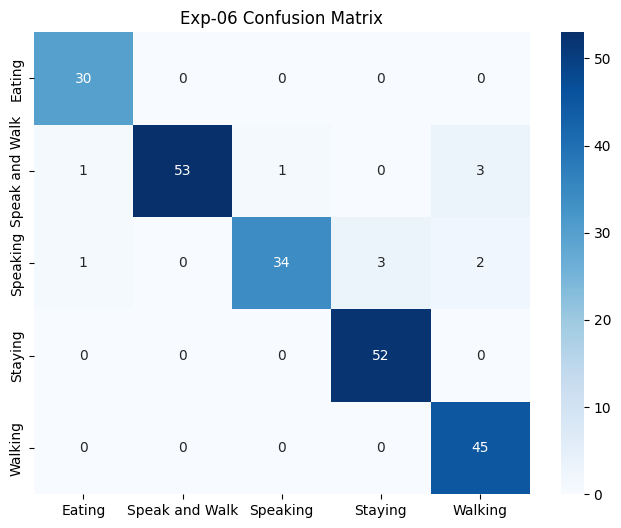

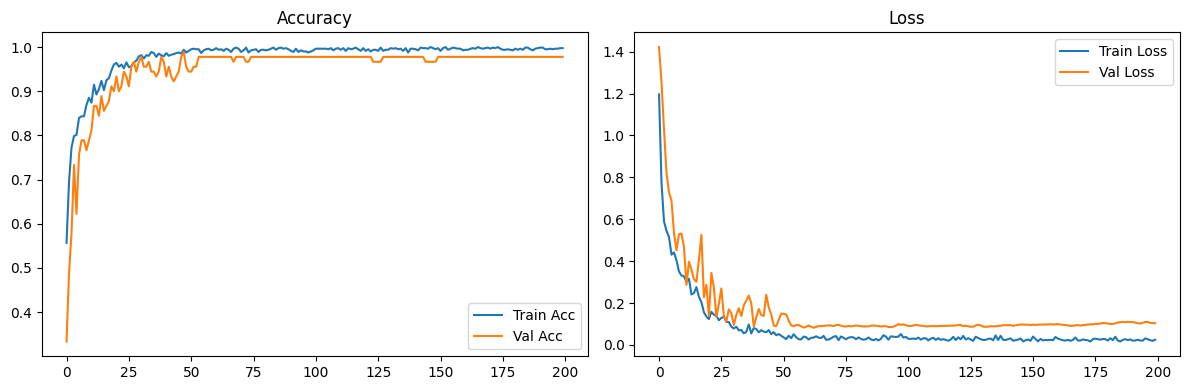

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks
import matplotlib.pyplot as plt
import seaborn as sns

# ------------- Load & Preprocess Dataset -------------
df = pd.read_csv(r"E:\AllData.csv")
df = df.drop(['Time', 'Person'], axis=1)

sensor_cols = ['Acc_x', 'Acc_y', 'Acc_z', 'Gry_x', 'Gry_y', 'Gry_Z']
df[sensor_cols] = (df[sensor_cols] - df[sensor_cols].mean()) / df[sensor_cols].std()

# Add rolling stats
window_size = 128
for col in sensor_cols:
    df[f'{col}_mean'] = df[col].rolling(window_size, min_periods=1).mean()
    df[f'{col}_std'] = df[col].rolling(window_size, min_periods=1).std().fillna(0)

all_feats = sensor_cols + [f'{c}_{s}' for c in sensor_cols for s in ['mean', 'std']]

le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

# ------------- Sliding Window ------------------
stride = window_size // 2
X, y = [], []
values = df[all_feats].values
labels = df['Class'].values
for start in range(0, len(values) - window_size + 1, stride):
    end = start + window_size
    X.append(values[start:end])
    y.append(np.bincount(labels[start:end]).argmax())
X = np.array(X)
y = np.array(y)

# ------------- Train/Test Split ------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
num_classes = len(np.unique(y))
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight = dict(enumerate(class_weights))

# ------------- Build Model for Exp-06 (GRU Block instead of Transformer) ------------------
def build_model_exp06(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    # CNN Layers
    x = layers.Conv1D(64, 5, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv1D(64, 5, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv1D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv1D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)

    # BiLSTM + residual
    lstm_input = x
    x_lstm = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x_lstm = layers.BatchNormalization()(x_lstm)
    proj = layers.Dense(256)(lstm_input)
    x = layers.Add()([x_lstm, proj])
    x = layers.Dropout(0.3)(x)

    # GRU block replacing Transformer
    x = layers.GRU(128, return_sequences=True)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.GRU(128, return_sequences=True)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Classification head
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

# ------------- Compile & Train ------------------
input_shape = (window_size, len(all_feats))
model = build_model_exp06(input_shape, num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
history = model.fit(
    X_train, y_train_cat,
    epochs=200,
    batch_size=64,
    validation_split=0.1,
    callbacks=[reduce_lr],
    class_weight=class_weight,
    verbose=1
)

# ------------- Evaluate ------------------
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
print("=== Exp-06: GRU Block Evaluation ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC (macro):", roc_auc_score(y_test_cat, y_pred_probs, multi_class='ovr'))

# ------------- Confusion Matrix & Plots ------------------
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Exp-06 Confusion Matrix')
plt.show()
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()


Ehheeee run kortesi 9/7/2025


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks
import matplotlib.pyplot as plt
import seaborn as sns

# ------------- Load & Preprocess Dataset -------------
df = pd.read_csv(r"E:\AllData.csv")
df = df.drop(['Time', 'Person'], axis=1)

sensor_cols = ['Acc_x', 'Acc_y', 'Acc_z', 'Gry_x', 'Gry_y', 'Gry_Z']
df[sensor_cols] = (df[sensor_cols] - df[sensor_cols].mean()) / df[sensor_cols].std()

# Add rolling stats
window_size = 128
for col in sensor_cols:
    df[f'{col}_mean'] = df[col].rolling(window_size, min_periods=1).mean()
    df[f'{col}_std'] = df[col].rolling(window_size, min_periods=1).std().fillna(0)

all_feats = sensor_cols + [f'{c}_{s}' for c in sensor_cols for s in ['mean', 'std']]

le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

# ------------- Sliding Window ------------------
stride = window_size // 2
X, y = [], []
values = df[all_feats].values
labels = df['Class'].values

for start in range(0, len(values) - window_size + 1, stride):
    end = start + window_size
    X.append(values[start:end])
    y.append(np.bincount(labels[start:end]).argmax())

X = np.array(X)
y = np.array(y)

# ------------- Train/Test Split ------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
num_classes = len(np.unique(y))
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight = dict(enumerate(class_weights))

# ------------- Positional Encoding ------------------
class PositionalEncoding(layers.Layer):
    def __init__(self, length, dim):
        super().__init__()
        pos = np.arange(length)[:, None]
        i = np.arange(dim)[None, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(dim))
        angle_rads = pos * angle_rates
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.pos_encoding = tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

# ------------- Attention Block ------------------
def attention_block(x, num_heads=4, ff_dim=128, dropout_rate=0.2):
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=64)(x, x)
    attn = layers.Dropout(dropout_rate)(attn)
    x1 = layers.LayerNormalization(epsilon=1e-6)(x + attn)

    ffn = layers.Dense(ff_dim * 2, activation='gelu')(x1)
    ffn = layers.Dropout(dropout_rate)(ffn)
    ffn = layers.Dense(ff_dim, activation='gelu')(ffn)
    ffn = layers.Dropout(dropout_rate)(ffn)
    ffn = layers.Dense(x.shape[-1])(ffn)

    return layers.LayerNormalization(epsilon=1e-6)(x1 + ffn)

# ------------- Build Model ------------------
def build_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # CNN Layers
    x = layers.Conv1D(64, 5, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv1D(64, 5, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv1D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv1D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)

    # BiLSTM + residual
    lstm_input = x
    x_lstm = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x_lstm = layers.BatchNormalization()(x_lstm)
    lstm_input_proj = layers.Dense(256)(lstm_input)
    x = layers.Add()([x_lstm, lstm_input_proj])
    x = layers.Dropout(0.3)(x)

    # Positional Encoding + Attention
    x = layers.Dense(128)(x)
    x = PositionalEncoding(x.shape[1], 128)(x)

    for _ in range(3):
        x = attention_block(x, num_heads=4, ff_dim=128, dropout_rate=0.2)

    # Classification head
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

# ------------- Compile & Train ------------------
input_shape = (window_size, len(all_feats))
model = build_model(input_shape, num_classes)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

history = model.fit(
    X_train, y_train_cat,
    epochs=200,
    batch_size=64,
    validation_split=0.1,
    callbacks=[reduce_lr],
    class_weight=class_weight,
    verbose=1
)

# ------------- Evaluate ------------------
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("=== Hybrid Model Evaluation ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC (macro):", roc_auc_score(y_test_cat, y_pred_probs, multi_class='ovr'))

# ------------- Confusion Matrix ------------------
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ------------- Training History ------------------
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.tight_layout()
plt.show()


Epoch 1/200
13/13 [==============================] - 11s 178ms/step - loss: 1.1206 - accuracy: 0.5309 - val_loss: 1.5111 - val_accuracy: 0.3444 - lr: 0.0010
Epoch 2/200
13/13 [==============================] - 1s 54ms/step - loss: 0.6686 - accuracy: 0.7494 - val_loss: 2.1017 - val_accuracy: 0.3000 - lr: 0.0010
Epoch 3/200
13/13 [==============================] - 1s 52ms/step - loss: 0.5964 - accuracy: 0.7790 - val_loss: 1.0863 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 4/200
13/13 [==============================] - 1s 52ms/step - loss: 0.5525 - accuracy: 0.7963 - val_loss: 0.8924 - val_accuracy: 0.6444 - lr: 0.0010
Epoch 5/200
13/13 [==============================] - 1s 51ms/step - loss: 0.4806 - accuracy: 0.8309 - val_loss: 0.8139 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 6/200
13/13 [==============================] - 1s 50ms/step - loss: 0.4209 - accuracy: 0.8568 - val_loss: 0.5850 - val_accuracy: 0.7556 - lr: 0.0010
Epoch 7/200
13/13 [==============================] - 1s 51ms/step - 

KeyboardInterrupt: 